## EP applied to basic logistic regression

In [1]:
import copy
from itertools import izip
from math import sqrt
import numpy as np
from operator import mul
import matplotlib.mlab as mlab
from scipy.stats import bernoulli, norm
from scipy import optimize, stats
import matplotlib.pyplot as plt
from matplotlib.mlab import bivariate_normal
from scipy import integrate
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.utils import shuffle
from sklearn import linear_model, datasets
%matplotlib inline 


In [2]:
d = 1
N = 100
w = 0.5
clutter_var = 10
prior_var = 100
tol = 10**4

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

1.12157302759
-0.599787797542


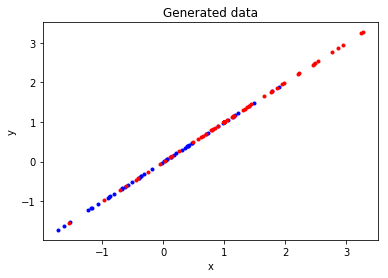

[ 1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.
  1.  0.  1.  1.  1.  0.  1.  1.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.
  1.  0.  0.  0.  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.  0.  1.  0.  0.
  0.  1.  1.  0.  1.  0.  0.  0.  1.  1.]


In [4]:
other_label = 0
def generate_class_data():
    # create data set 
    np.random.seed(0)
    n_samples = 100

    # Gaussian mean=0, variance=1
    data = np.random.randn(n_samples,1)

    # seperate shifting them 1 away
    data[0:50] = data[0:50] + 1
    #data[0:250] = data[0:250] - 2

    # define labels
    y = other_label*np.ones(100)
    y[0:50] = 1
    return data, y


data, y = generate_class_data()
logreg = linear_model.LogisticRegression(C=1e5)
logreg.fit(data, y)
w_true = logreg.coef_[0][0]
w0_true = logreg.intercept_[0]
print w_true
print w0_true

data = np.hstack((np.ones([data.shape[0],1]),data))
data, y = shuffle(data, y, random_state=0)

plt.plot(data[y==other_label],data[y==other_label],"bo", markersize = 3)
plt.plot(data[y==1],data[y==1],"ro", markersize = 3)
plt.title("Generated data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()
print y
#print data



In [6]:
def project_subspace(Xi, mu, sig, Mi, Vi):
    
    XT = Xi[:,None] #Xi.T
    X = Xi[None,:] #Xi
    
    # project cavity on 1D subspace
    scalar_moment = np.linalg.inv(X.dot(sig).dot(XT))
    scalar_moment2 = X.dot(mu)
    
    
    V_cavity = 1/(scalar_moment - 1/Vi)
    M_cavity = V_cavity * (scalar_moment * scalar_moment2 - Mi/Vi)

    return M_cavity[0][0], V_cavity[0][0]


def compute_cavity1(Xi, r_i, A_i, r, A):
    

    XT = Xi[:,None] #Xi.T
    X = Xi[None,:] #Xi
    
    scalar_moment = np.linalg.inv(X.dot(A).dot(XT))
    scalar_moment2 = X.dot(np.linalg.inv(A).dot(r))
    
    Mi = X.dot( np.linalg.inv(A_i).dot(r_i) )
    Vi = X.dot((np.linalg.inv(A_i))).dot(XT)

    V_cavity = np.linalg.inv( scalar_moment - 1/Vi )
    
    M_cavity = V_cavity * ( scalar_moment*scalar_moment2 -  Mi/Vi)
    
    return M_cavity[0][0], V_cavity[0][0]

Xi = np.array([1,1])
presmui = np.array([2,1])
presi = np.array([[1, 0.5], [1,1]])
pres_mu = np.array([0.5,1.2])
pres = np.array([[1.3, 1.5], [1.7,1.3]])


cavity_M, cavity_V = compute_cavity1(Xi, presmui, presi, pres_mu, pres)
print cavity_M, cavity_V

1.10174418605 -1.20833333333


In [8]:
def logit_i(x):
    trunc = 8.
    exponent = np.clip(x, -trunc, trunc)
    exponent = np.float64(exponent)
    return  pow(np.e, exponent) / (1 + pow(np.e, exponent))  
    

def compute_moments(y, M_cavity, V_cavity):
    
    cavity_m = M_cavity
    
    if V_cavity < 0:
        sd = -sqrt(-V_cavity)
    else:
        sd = sqrt(V_cavity)

    lower_bound = M_cavity - 10*sqrt(np.abs(V_cavity))
    upper_bound = M_cavity + 10*sqrt(np.abs(V_cavity))
    
    f = lambda x: gaussian(x, cavity_m, sd) * \
                pow(logit_i(x), y) * pow((1-logit_i(x)), (1 - y))
    E0 = integrate.quad(f, lower_bound, upper_bound)[0]

    f = lambda x: gaussian(x, cavity_m, sd) * \
                pow(logit_i(x), y) * pow((1-logit_i(x)), (1 - y)) * x
    E1 = integrate.quad(f, lower_bound, upper_bound)[0] 
    
    f = lambda x: gaussian(x, cavity_m, sd) * \
                pow(logit_i(x), y) * pow((1-logit_i(x)), (1 - y)) * (x**2)
    E2 = integrate.quad(f, lower_bound, upper_bound)[0] 
    
    if E0 == 0:
        print "WARNING E0 was 0"
        E0 = 0.0001
        
    M_new = E1 / E0
    V_new = E2 / E0 - (E1 / E0)**2 


    return M_new, V_new


def ll2log(x, y, mu, sig):
    if sig < 0:
        sig = -sqrt(-sig)
    else:
        sig = sqrt(sig)
    trunc = 7.
    exponent = np.clip(x, -trunc, trunc)
    exponent = np.float64(exponent)
    et = np.exp(exponent)

    z = np.log(et / (1 + et))
    e = y*z + (1-y)*np.log(1-et / (1 + et)) + np.log(gaussian(x, mu, (sig)))
    return e

def ll(x, y, mu, sig):
    if sig < 0:
        sig = -sqrt(-sig)
    else:
        sig = sqrt(sig)
        
    et = np.exp(x)
    z = np.log(et / (1 + et))
    e = y*z + (1-y)*np.log(1-et / (1 + et)) + np.log(gaussian(x, mu, (sig)))
    return e
'''
max_x = optimize.minimize(lambda x: -ll2log(x, y[i], M_cavity, V_cavity),  M_cavity)
M_new = max_x.x[0]
V_new = max_x.hess_inv[0][0]
print M_new
print V_new
max_x = optimize.minimize(lambda x: -ll(x, y[i], M_cavity, V_cavity),  M_cavity)
M_new = max_x.x[0]
V_new = max_x.hess_inv[0][0]
print M_new
print V_new
'''

'\nmax_x = optimize.minimize(lambda x: -ll2log(x, y[i], M_cavity, V_cavity),  M_cavity)\nM_new = max_x.x[0]\nV_new = max_x.hess_inv[0][0]\nprint M_new\nprint V_new\nmax_x = optimize.minimize(lambda x: -ll(x, y[i], M_cavity, V_cavity),  M_cavity)\nM_new = max_x.x[0]\nV_new = max_x.hess_inv[0][0]\nprint M_new\nprint V_new\n'

In [9]:
def transform_back(Xi, Mi, Vi):
    
    V_inv = 1 / Vi
    
    r = Xi.T * Mi/Vi
    
    XT = Xi[:,None] #Xi.T
    X = Xi[None,:] #Xi
    
    A = V_inv*(XT).dot(X) # legit 
    #A = np.identity(2) * (Xi.T * V_inv).dot(Xi) # spherical
    
    return r, A

transform_back(np.array([1,2.5]), 2, 0.5)

(array([  4.,  10.]), array([[  2. ,   5. ],
        [  5. ,  12.5]]))

In [10]:
def compute_cavity(r_i, A_i, r, A):

    # remove factor
    r_cavity = r - r_i  
    A_cavity = A - A_i

    return r_cavity, A_cavity

def update_post(r_i, A_i, cavity_r, cavity_A):
    
    r = cavity_r + r_i  
    
    A = cavity_A + A_i
    
    return r, A


In [11]:
def ss_to_cov(r, A):
    
    sig = np.linalg.inv(A)
    mu = sig.dot(r)
    
    return mu, sig

In [12]:
# initialise
prior_post = 100
prior_factor = 100000
r_new = np.array([0,0])
A_new = np.linalg.inv(np.identity(2) * prior_post) 
                         
r = [] 

A = []
for i in range(N):
    A.append(np.linalg.inv(np.identity(2) * prior_factor))
    r.append(np.array([0, 0]))
    
    
r_old = r_new
A_old = A_new


def plot_projected(M_new, V_new, M_cavity, V_cavity, y):
    
    
    if V_new < 0:
        sd1 = -sqrt(-V_new)
    else:
        sd1 = sqrt(V_new)
    if V_cavity < 0:
        sd2 = -sqrt(-V_cavity)
    else:
        sd2 = sqrt(V_cavity)
        
    x = np.linspace(-8,8,100)    
    
    plt.plot(x, gaussian(x, M_new, sd1), label="New Aprrox")
    plt.plot(x, mlab.normpdf(x, M_cavity, sd2), label="Cavity/Prior")
    
    
    # parts of approximations
    if V_cavity < 0:
        sd = -sqrt(-V_cavity)
    else:
        sd = sqrt(V_cavity)
    f = lambda x: gaussian(x, M_cavity, sd) * pow(logit_i(x), y) * pow((1-logit_i(x)), (1 - y))
    plt.plot(x, map(f, x), label="Tilted distribution")
    
    f = lambda x: pow(logit_i(x), y) * pow((1-logit_i(x)), (1 - y))
    plt.plot(x, map(f, x), label="Likelihood")
    
    plt.legend()
    plt.show()
    
    
def plot_posterior(m_x, v_x):
    N = 80
    limit = 8
    X = np.linspace(-limit, limit, N)
    Y = np.linspace(-limit, limit, N)
    X, Y = np.meshgrid(X, Y)

    #v_x = -0.5*v_x
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y

    z = multivariate_gaussian(pos, m_x, v_x)

    limits = 3
    plt.imshow(z, extent=(-limit, limit, limit, -limit))
    plt.colorbar()
    plt.show()
    
def plot_posterior_1d(r_old, A_old, r_new, A_new, ri, Ai):
    
    
    mu_old, sig_old = ss_to_cov(r_old, A_old)
    mu_new, sig_new = ss_to_cov(r_new, A_new)
    mu_i, sig_i = ss_to_cov(ri, Ai)
    

    x = np.linspace(-10,10,100)
    
    if sig_i[0][0] < 0:
        sdi = -sqrt(-sig_i[0][0])
    else:
        sdi = sqrt(sig_i[0][0])
        
    if sig_i[1][1] < 0:
        sdi2 = -sqrt(-sig_i[1][1])
    else:
        sdi2 = sqrt(sig_i[1][1])
        
    
    plt.plot((w_true, w_true), (0, 1.5), label="target mean")
    plt.plot((w0_true, w0_true), (0, 1.5), label="target mean")
    plt.plot(x, gaussian(x, mu_old[0], sqrt(sig_old[0][0])), label="Old posterior")
    plt.plot(x, gaussian(x, mu_new[0], sqrt(sig_new[0][0])), label="New posterior")
    plt.plot(x, mlab.normpdf(x, mu_i[0], sdi), label="Updated factor")
    
    plt.plot(x, gaussian(x, mu_old[1], sqrt(sig_old[1][1])), label="Old posterior 2")
    plt.plot(x, gaussian(x, mu_new[1], sqrt(sig_new[1][1])), label="New posterior 2")
    plt.plot(x, mlab.normpdf(x, mu_i[1], sdi2), label="Updated factor 2")
    
    plt.legend()
    plt.show()
    
def sanity_check(M_new, V_new, Xi):
    XT = Xi[:,None] #Xi.T
    X = Xi[None,:] #Xi
    
    A = (XT * 1/V_new).dot(X) 
    r = M_new/V_new * Xi
    
    sig = np.linalg.inv(A)
    mu = sig.dot(r)
    
    return mu, sig

def subtract_moments(M, V, M_cavity, V_cavity):
    
    Vi = 1/(1/V - 1/V_cavity)
    Mi = Vi * (M/V - M_cavity/V_cavity)
    
    return Mi, Vi


def project_factor_subspace(Xi, r, A):
    XT = Xi[:,None] #Xi.T
    X = Xi[None,:] #Xi
    
    sig = np.linalg.inv(A)
    mu = sig.dot(r)
    
    Mi = X.dot(mu)
    Vi = X.dot(sig).dot(XT)
    
    return Mi, Vi


3.33118540192


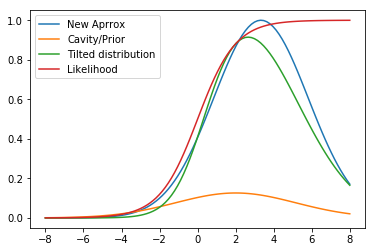

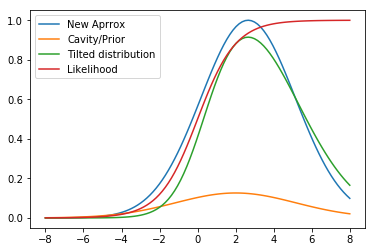

2.65612051921


In [13]:
M_cavity = 2
V_cavity = 10
M_new, V_new = compute_moments(1, M_cavity, V_cavity)
print M_new
plot_projected(M_new, V_new, M_cavity, V_cavity, 1)
max_x = optimize.minimize(lambda x: -ll(x, y[i], M_cavity, V_cavity),  M_cavity)
M_new = max_x.x[0]
V_new = max_x.hess_inv[0][0]
plot_projected(M_new, V_new, M_cavity, V_cavity, 1)
print M_new

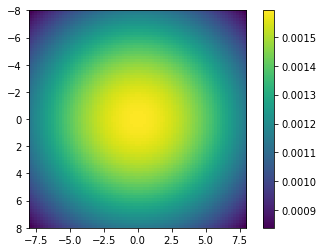

Iteration  0
factor  0
Data
[ 1.          1.04575852]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [0 0] [[ 0.01  0.  ]
 [ 0.    0.01]]
[0 0]
[[ 0.00999  0.     ]
 [ 0.       0.00999]]
Cavity
     0
0  0.0
1  0.0
          0         1
0  100.1001    0.0000
1    0.0000  100.1001

Projected cavity
0.0 209.570658309

Matched moments 
11.4550394229 78.3527289231

Updated factor 
18.2950619938 125.138638123

Updated factor
      0
0  16.0
1 -16.0
              0             1
0 -6.770936e+17  6.474665e+17
1  6.474665e+17 -6.191358e+17

New posterior
          0
0  5.471427
1  5.721792
           0          1
0  70.163585 -31.306366
1 -31.306366  67.361201


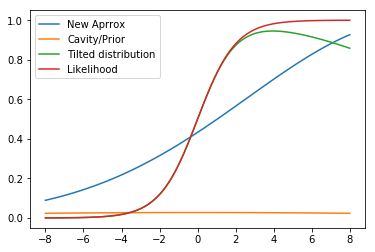

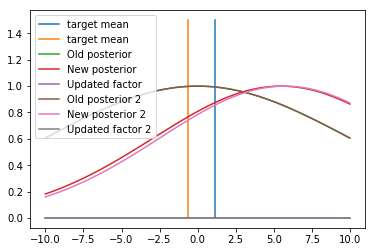

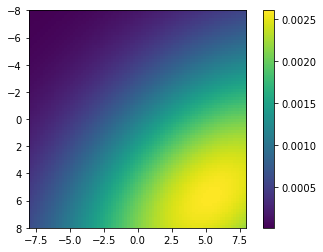

factor  1
Data
[ 1.          1.17877957]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 0.14619835  0.15288817] [[ 0.01798114  0.0083568 ]
 [ 0.0083568   0.01872919]]
[ 0.14619835  0.15288817]
[[ 0.01797114  0.0083568 ]
 [ 0.0083568   0.01871919]]
Cavity
          0
0  5.473476
1  5.723934
           0          1
0  70.222670 -31.349468
1 -31.349468  67.416428

Projected cavity
12.220758838 89.990675567

Matched moments 
-3.95976488488 19.1011721314

Updated factor 
-8.31960595906 24.247981731

Updated factor
      0
0  32.0
1   0.0
              0             1
0 -4.667991e+17  3.960021e+17
1  3.960021e+17 -3.359424e+17

New posterior
          0
0 -0.508260
1 -2.928048
           0          1
0  60.534235 -45.362819
1 -45.362819  47.147518


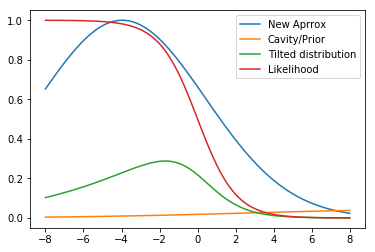

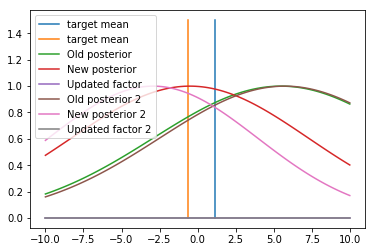

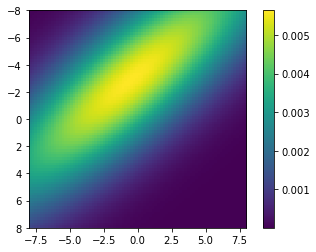

factor  2
Data
[ 1.          1.97873798]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.19690674 -0.2515571 ] [[ 0.05921168  0.05697031]
 [ 0.05697031  0.07602381]]
[-0.19690674 -0.2515571 ]
[[ 0.05920168  0.05697031]
 [ 0.05697031  0.07601381]]
Cavity
          0
0 -0.507238
1 -2.929199
           0          1
0  60.591514 -45.411715
1 -45.411715  47.190367

Projected cavity
-6.3029414352 65.6223111933

Matched moments 
4.24948171768 17.7032006485

Updated factor 
8.14796109843 24.243457962

Updated factor
       0
0    0.0
1  128.0
              0             1
0  3.490188e+18 -1.763845e+18
1 -1.763845e+18  8.913991e+17

New posterior
          0
0 -5.212371
1  4.782204
           0          1
0  51.062820 -29.794813
1 -29.794813  21.595293


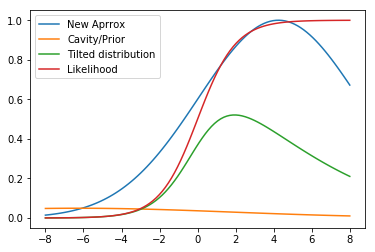

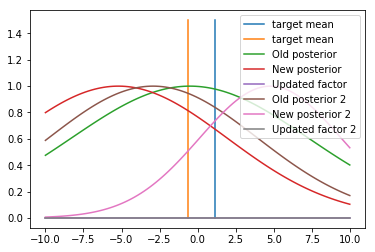

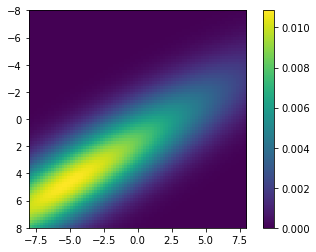

factor  3
Data
[ 1.          0.42833187]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 0.13918232  0.41347509] [[ 0.10044992  0.13858977]
 [ 0.13858977  0.23751734]]
[ 0.13918232  0.41347509]
[[ 0.10043992  0.13858977]
 [ 0.13858977  0.23750734]]
Cavity
          0
0 -5.216461
1  4.784792
           0          1
0  51.097796 -29.816477
1 -29.816477  21.608843

Projected cavity
-3.16478964417 29.5080890885

Matched moments 
-5.65105344388 16.2086285641

Updated factor 
-8.68117082102 35.9627862193

Updated factor
      0
0  32.0
1   0.0
              0             1
0  6.069764e+17 -1.417070e+18
1 -1.417070e+18  3.308347e+18

New posterior
          0
0 -8.443881
1  6.516183
           0          1
0  28.665568 -17.782417
1 -17.782417  15.153015


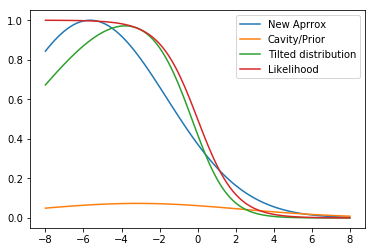

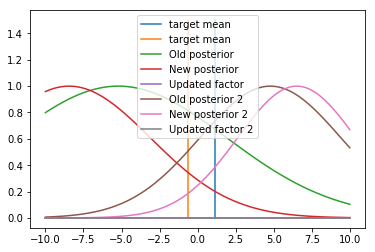

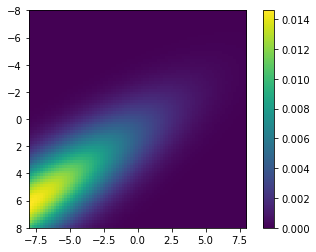

factor  4
Data
[ 1.         -0.68481009]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.10221085  0.31007871] [[ 0.12824645  0.15050019]
 [ 0.15050019  0.24260895]]
[-0.10221085  0.31007871]
[[ 0.12823645  0.15050019]
 [ 0.15050019  0.24259895]]
Cavity
          0
0 -8.447461
1  6.518673
           0          1
0  28.676951 -17.790212
1 -17.790212  15.158476

Projected cavity
-12.9115135322 60.1515768943

Matched moments 
-13.764731858 48.9683183157

Updated factor 
-17.5007329774 263.386699311

Updated factor
      0
0   0.0
1  64.0
              0             1
0  5.419991e+18  7.914589e+18
1  7.914589e+18  1.155735e+19

New posterior
          0
0 -9.027037
1  6.918262
           0          1
0  23.516731 -14.232491
1 -14.232491  12.705601


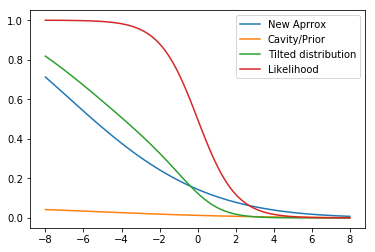

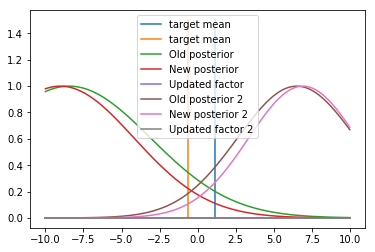

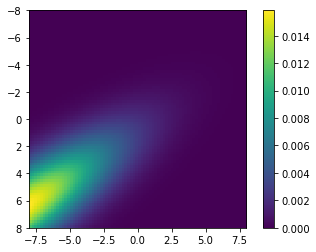

factor  5
Data
[ 1.          0.97663904]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.16865586  0.35558092] [[ 0.13203314  0.14790018]
 [ 0.14790018  0.24437947]]
[-0.16865586  0.35558092]
[[ 0.13202314  0.14790018]
 [ 0.14790018  0.24436947]]
Cavity
          0
0 -9.030145
1  6.920427
           0          1
0  23.524290 -14.237648
1 -14.237648  12.709242

Projected cavity
-2.27048292392 7.83593668884

Matched moments 
-3.25833375245 5.22321125936

Updated factor 
-5.23318863463 15.6651564987

Updated factor
     0
0  0.0
1  0.0
              0             1
0 -9.359114e+17  9.582981e+17
1  9.582981e+17 -9.812204e+17

New posterior
           0
0 -10.242409
1   7.150461
           0          1
0  19.587138 -13.490551
1 -13.490551  12.567476


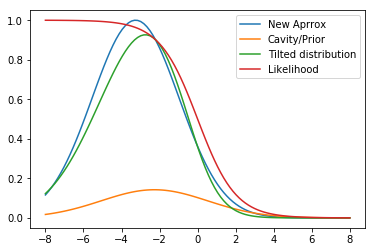

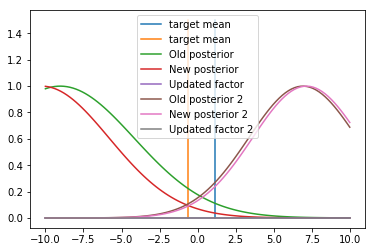

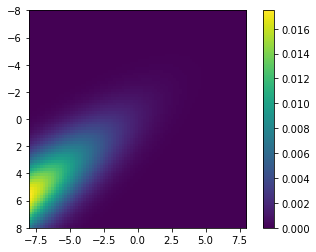

factor  6
Data
[ 1.          2.49407907]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.50272138  0.0293195 ] [[ 0.19585909  0.21024485]
 [ 0.21024485  0.30525771]]
[-0.50272138  0.0293195 ]
[[ 0.19584909  0.21024485]
 [ 0.21024485  0.30524771]]
Cavity
           0
0 -10.245381
1   7.152742
           0          1
0  19.592796 -13.494891
1 -13.494891  12.570876

Projected cavity
7.59172551443 30.4705295465

Matched moments 
8.57435471521 22.749675345

Updated factor 
11.4696943654 89.7821195283

Updated factor
     0
0  0.0
1  4.0
              0             1
0 -6.194105e+17  2.483524e+17
1  2.483524e+17 -9.957679e+16

New posterior
           0
0 -10.698646
1   7.728257
           0          1
0  17.947888 -11.406335
1 -11.406335   9.919016


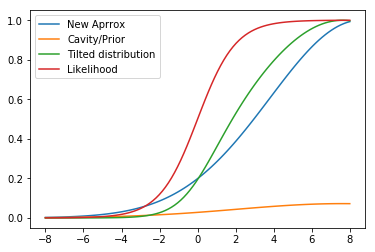

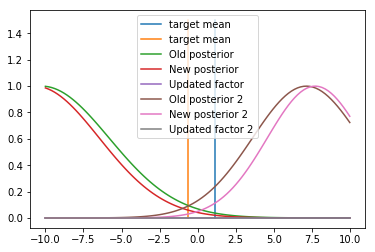

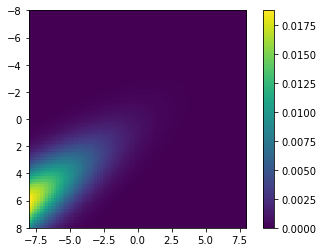

factor  7
Data
[ 1.         -1.23482582]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.37497106  0.34793889] [[ 0.20698716  0.23802409]
 [ 0.23802409  0.37453133]]
[-0.37497106  0.34793889]
[[ 0.20697716  0.23802409]
 [ 0.23802409  0.37452133]]
Cavity
           0
0 -10.701448
1   7.730244
           0          1
0  17.952411 -11.409514
1 -11.409514   9.921302

Projected cavity
-20.2466081891 61.256883906

Matched moments 
-20.3741724456 58.7905491519

Updated factor 
-23.4149489166 1460.19344628

Updated factor
      0
0   0.0
1  32.0
              0             1
0  1.272779e+19  1.030736e+19
1  1.030736e+19  8.347217e+18

New posterior
           0
0 -10.768165
1   7.779511
           0          1
0  17.277637 -10.911231
1 -10.911231   9.553348


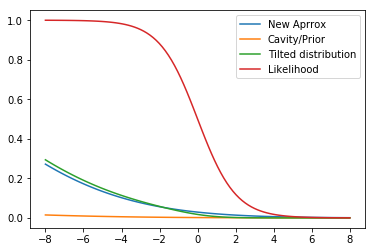

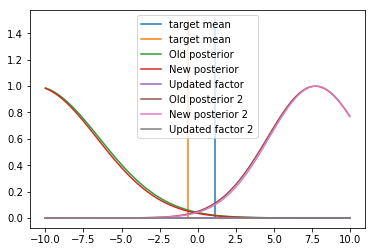

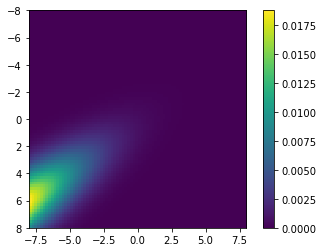

factor  8
Data
[ 1.         -0.02818223]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.39100657  0.36773996] [[ 0.207662    0.23717843]
 [ 0.23717843  0.37556557]]
[-0.39100657  0.36773996]
[[ 0.207652    0.23717843]
 [ 0.23717843  0.37555557]]
Cavity
           0
0 -10.770875
1   7.781429
           0          1
0  17.281814 -10.914159
1 -10.914159   9.555452

Projected cavity
-10.989374664 17.9034322522

Matched moments 
-11.079504763 17.0642783117

Updated factor 
-12.9123092325 364.068064236

Updated factor
       0
0   -8.0
1  256.0
              0             1
0 -1.112067e+18 -3.945987e+19
1 -3.945987e+19 -1.400168e+21

New posterior
           0
0 -10.859387
1   7.837706
           0          1
0  16.471842 -10.399174
1 -10.399174   9.228021


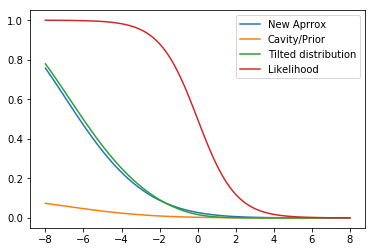

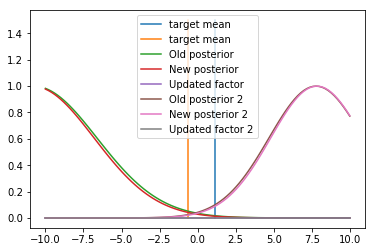

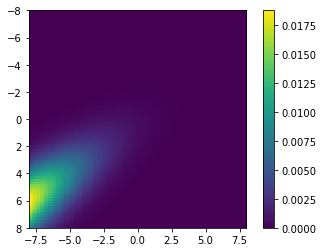

factor  9
Data
[ 1.          0.70657317]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.42647332  0.36873949] [[ 0.21039874  0.23710102]
 [ 0.23710102  0.37555775]]
[-0.42647332  0.36873949]
[[ 0.21038874  0.23710102]
 [ 0.23710102  0.37554775]]
Cavity
           0
0 -10.861992
1   7.839559
           0          1
0  16.475638 -10.401847
1 -10.401847   9.229954

Projected cavity
-5.321701088 6.38360805449

Matched moments 
-5.51368090112 5.66788188467

Updated factor 
-7.0339814726 50.5522055457

Updated factor
     0
0 -8.0
1  0.0
              0             1
0 -4.817094e+17  6.817545e+17
1  6.817545e+17 -9.648746e+17

New posterior
           0
0 -11.136270
1   7.956178
           0         1
0  15.012897 -9.779915
1  -9.779915  8.965519


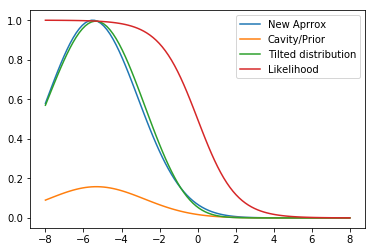

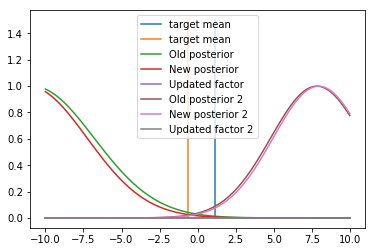

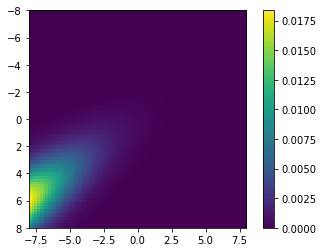

factor  10
Data
[ 1.         -1.18063218]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.56561624  0.27042483] [[ 0.23017027  0.25107812]
 [ 0.25107812  0.3854236 ]]
[-0.56561624  0.27042483]
[[ 0.23016027  0.25107812]
 [ 0.25107812  0.3854136 ]]
Cavity
           0
0 -11.138721
1   7.957981
           0         1
0  15.016108 -9.782261
1  -9.782261  8.967280

Projected cavity
-20.5339302707 50.6135292638

Matched moments 
-20.5890521686 49.549389443

Updated factor 
-23.1556851748 2356.71048441

Updated factor
      0
0 -16.0
1   0.0
              0             1
0 -7.332433e+18 -6.210599e+18
1 -6.210599e+18 -5.260401e+18

New posterior
           0
0 -11.167650
1   7.980162
           0         1
0  14.722954 -9.557481
1  -9.557481  8.794927


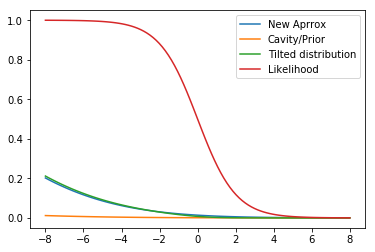

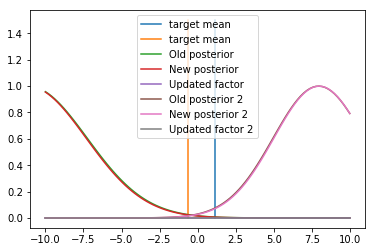

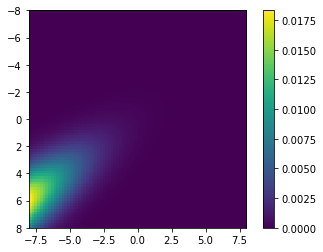

factor  11
Data
[ 1.          0.20827498]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.57544166  0.28202505] [[ 0.23058459  0.25057715]
 [ 0.25057715  0.38600505]]
[-0.57544166  0.28202505]
[[ 0.23057459  0.25057715]
 [ 0.25057715  0.38599505]]
Cavity
           0
0 -11.170057
1   7.981932
           0         1
0  14.726035 -9.559729
1  -9.559729  8.796614

Projected cavity
-9.5065952318 11.124481979

Matched moments 
-9.55769965966 10.7546414484

Updated factor 
-11.0437720412 323.490275139

Updated factor
       0
0  -32.0
1  128.0
              0             1
0  4.744144e+18 -2.277827e+19
1 -2.277827e+19  1.093663e+20

New posterior
           0
0 -11.228521
1   8.017408
           0         1
0  14.241361 -9.265627
1  -9.265627  8.618153


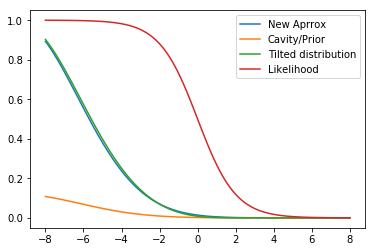

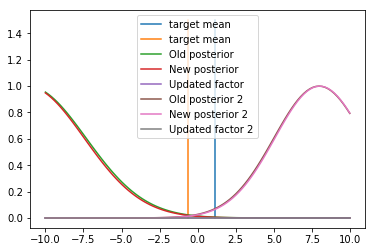

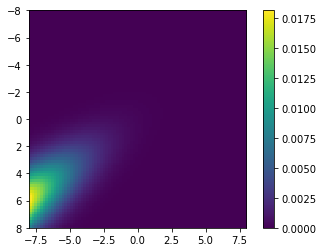

factor  12
Data
[ 1.         -0.31155253]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.60958109  0.27491466] [[ 0.23366587  0.25122099]
 [ 0.25122099  0.38612915]]
[-0.60958109  0.27491466]
[[ 0.23365587  0.25122099]
 [ 0.25122099  0.38611915]]
Cavity
           0
0 -11.230863
1   8.019139
           0         1
0  14.244248 -9.267746
1  -9.267746  8.619754

Projected cavity
-13.7289739917 20.8553046908

Matched moments 
-13.7633513638 20.4507530457

Updated factor 
-15.5011842351 1054.27005698

Updated factor
      0
0  32.0
1   0.0
              0             1
0  1.853737e+19  5.949997e+19
1  5.949997e+19  1.909789e+20

New posterior
           0
0 -11.259098
1   8.038840
           0         1
0  13.971263 -9.077276
1  -9.077276  8.486858


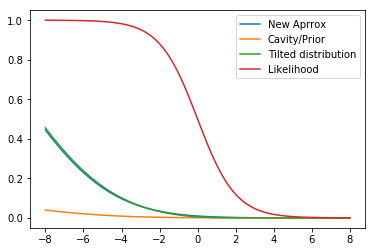

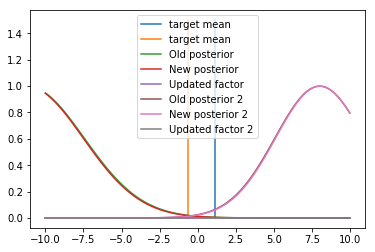

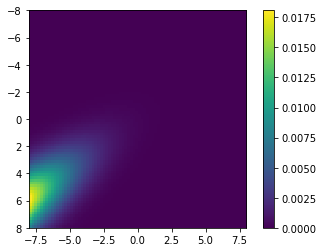

factor  13
Data
[ 1.          1.12167502]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.62428433  0.27949549] [[ 0.2346044   0.25092547]
 [ 0.25092547  0.38621122]]
[-0.62428433  0.27949549]
[[ 0.2345944   0.25092547]
 [ 0.25092547  0.38620122]]
Cavity
           0
0 -11.261402
1   8.040544
           0         1
0  13.974040 -9.079315
1  -9.079315  8.488403

Projected cavity
-2.24217523936 4.28561859871

Matched moments 
-0.0574539764351 2.47771856807

Updated factor 
2.93669633467 5.87342032064

Updated factor
     0
0  0.0
1  0.0
              0             1
0  5.161110e+16 -4.601252e+16
1 -4.601252e+16  4.102126e+16

New posterior
          0
0 -9.329219
1  8.265837
           0         1
0  12.560126 -9.244177
1  -9.244177  8.469180


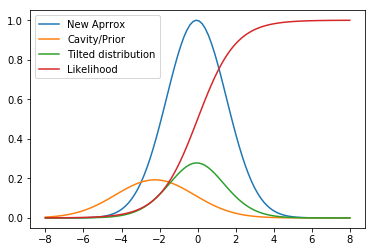

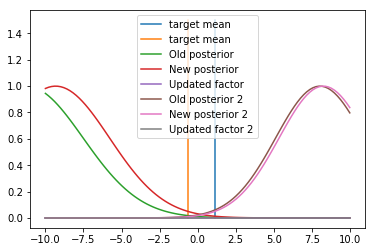

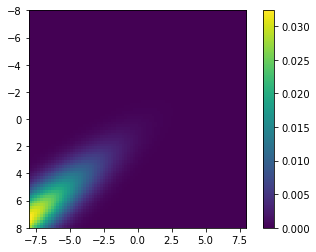

factor  14
Data
[ 1.          0.84864279]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [-0.12428668  0.84033036] [[ 0.40485294  0.44190023]
 [ 0.44190023  0.60041283]]
[-0.12428668  0.84033036]
[[ 0.40484294  0.44190023]
 [ 0.44190023  0.60040283]]
Cavity
          0
0 -9.331156
1  8.267400
           0         1
0  12.562559 -9.246122
1  -9.246122  8.470752

Projected cavity
-2.31451641434 2.9696259266

Matched moments 
-0.541646822718 1.95588297153

Updated factor 
2.87887060493 5.72950051348

Updated factor
     0
0  0.0
1  0.0
              0             1
0 -6.028038e+16  7.103151e+16
1  7.103151e+16 -8.370013e+16

New posterior
          0
0 -6.515516
1  7.038978
           0         1
0  10.006071 -8.130764
1  -8.130764  7.984138


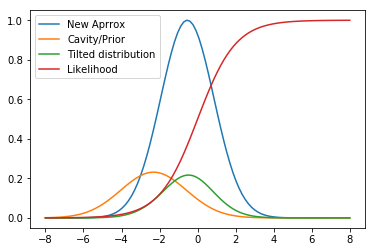

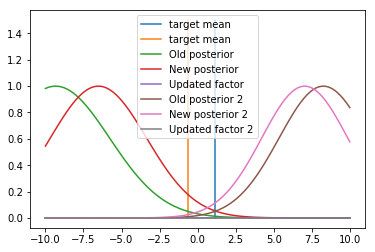

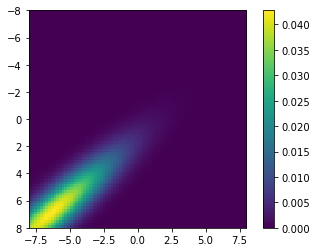

factor  15
Data
[ 1.          1.15494743]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 0.37817782  1.26674323] [[ 0.57937823  0.59001834]
 [ 0.59001834  0.7261022 ]]
[ 0.37817782  1.26674323]
[[ 0.57936823  0.59001834]
 [ 0.59001834  0.7260922 ]]
Cavity
          0
0 -6.516741
1  7.040070
           0         1
0  10.007734 -8.132227
1  -8.132227  7.985437

Projected cavity
1.61414612633 1.87494608519

Matched moments 
1.94744439469 1.53740627654

Updated factor 
3.46553155543 8.53989309035

Updated factor
      0
0  64.0
1 -64.0
              0             1
0  8.064455e+17 -6.982530e+17
1 -6.982530e+17  6.045755e+17

New posterior
          0
0 -6.407339
1  7.233925
          0         1
0  9.971366 -8.196669
1 -8.196669  7.871247


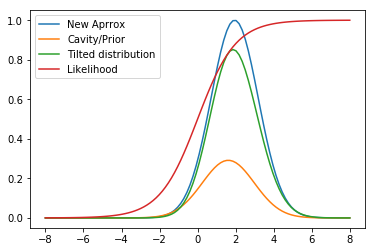

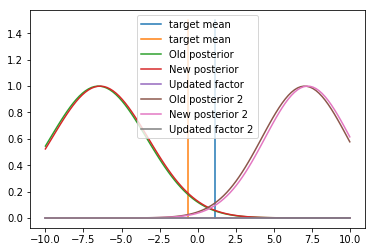

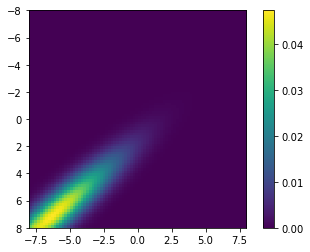

factor  16
Data
[ 1.         1.8644362]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 0.78398285  1.73542671] [[ 0.69646571  0.72525978]
 [ 0.72525978  0.88228895]]
[ 0.78398285  1.73542671]
[[ 0.69645571  0.72525978]
 [ 0.72525978  0.88227895]]
Cavity
          0
0 -6.408571
1  7.235020
          0         1
0  9.973033 -8.198132
1 -8.198132  7.872539

Projected cavity
7.07995943954 6.76855335382

Matched moments 
7.1500194234 6.43820034798

Updated factor 
8.51540797598 131.911324513

Updated factor
     0
0  8.0
1  0.0
              0             1
0  9.677134e+17 -5.190381e+17
1 -5.190381e+17  2.783888e+17

New posterior
          0
0 -6.463526
1  7.302057
          0         1
0  9.769573 -7.949940
1 -7.949940  7.569781


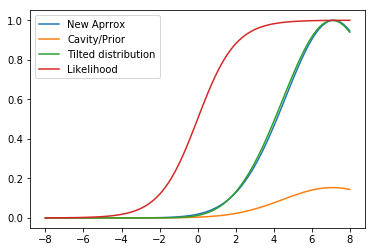

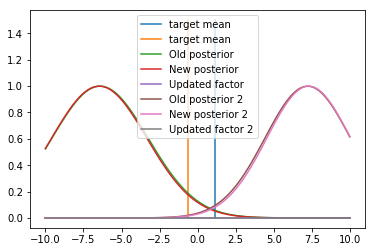

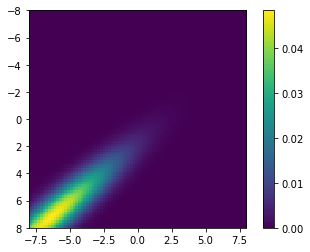

factor  17
Data
[ 1.          3.26975462]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 0.84853688  1.85578358] [[ 0.70403656  0.73939379]
 [ 0.73939379  0.90863091]]
[ 0.84853688  1.85578358]
[[ 0.70402656  0.73939379]
 [ 0.73939379  0.90862091]]
Cavity
          0
0 -6.464738
1  7.303124
          0         1
0  9.771160 -7.951319
1 -7.951319  7.570986

Projected cavity
17.4129846279 38.7129049973

Matched moments 
17.4776125831 37.6740399561

Updated factor 
19.8213204448 1403.90856556

Updated factor
     0
0  0.0
1  0.0
              0             1
0  1.624420e+19 -4.968017e+18
1 -4.968017e+18  1.519385e+18

New posterior
          0
0 -6.491810
1  7.331156
          0         1
0  9.588619 -7.762296
1 -7.762296  7.375251


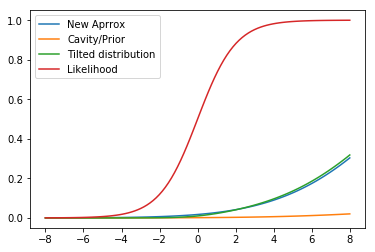

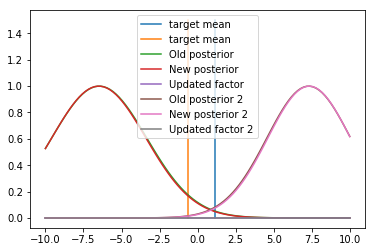

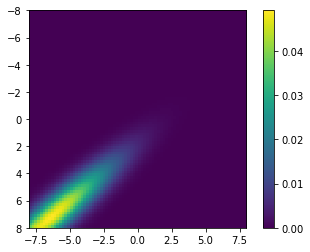

factor  18
Data
[ 1.         -0.98079647]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 0.86265555  1.90194817] [[ 0.70473886  0.74172283]
 [ 0.74172283  0.91623629]]
[ 0.86265555  1.90194817]
[[ 0.70472886  0.74172283]
 [ 0.74172283  0.91622629]]
Cavity
          0
0 -6.493001
1  7.332201
          0         1
0  9.590141 -7.763613
1 -7.763613  7.376397

Projected cavity
-13.6844077664 31.9149833698

Matched moments 
0.0700765300186 13.124400591

Updated factor 
9.67698249742 22.2912206358

Updated factor
      0
0  32.0
1   0.0
              0             1
0 -4.252679e+17 -4.335945e+17
1 -4.335945e+17 -4.420840e+17

New posterior
          0
0  0.921733
1  0.868324
          0         1
0  4.129504 -3.003242
1 -3.003242  3.226491


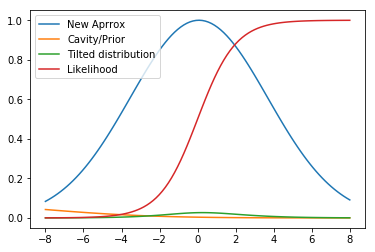

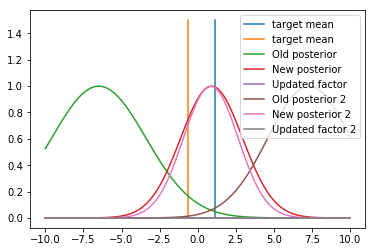

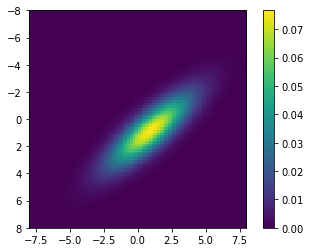

factor  19
Data
[ 1.          0.89678115]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 1.29677186  1.47616842] [[ 0.74958957  0.6977236 ]
 [ 0.6977236   0.95938058]]
[ 1.29677186  1.47616842]
[[ 0.74957957  0.6977236 ]
 [ 0.6977236   0.95937058]]
Cavity
          0
0  0.921745
1  0.868325
          0         1
0  4.129765 -3.003463
1 -3.003463  3.226686

Projected cavity
1.7004425482 1.33780891582

Matched moments 
1.92648214293 1.15437915614

Updated factor 
3.34901792489 8.41923758739

Updated factor
      0
0   0.0
1  32.0
              0             1
0 -3.741010e+17  4.171597e+17
1  4.171597e+17 -4.651745e+17

New posterior
          0
0  1.164428
1  0.849767
          0         1
0  3.918328 -2.987295
1 -2.987295  3.225449


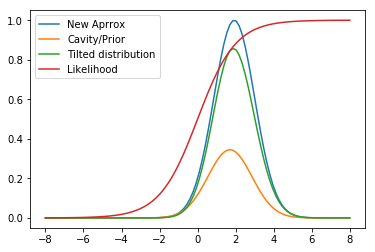

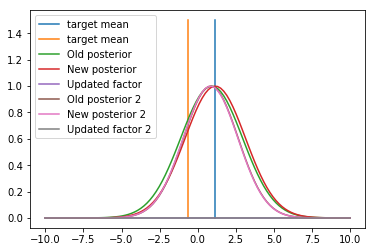

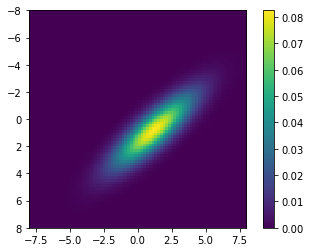

factor  20
Data
[ 1.         2.9507754]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 1.69455348  1.83289147] [[ 0.86835517  0.80423932]
 [ 0.80423932  1.05489187]]
[ 1.69455348  1.83289147]
[[ 0.86834517  0.80423932]
 [ 0.80423932  1.05488187]]
Cavity
          0
0  1.164449
1  0.849760
          0         1
0  3.918570 -2.987508
1 -2.987508  3.225642

Projected cavity
3.67195469992 14.3730966023

Matched moments 
4.82060851984 9.57327154669

Updated factor 
7.11160346315 28.6672024806

Updated factor
       0
0 -512.0
1   64.0
              0             1
0  6.504728e+18 -2.204413e+18
1 -2.204413e+18  7.470623e+17

New posterior
          0
0  0.773101
1  1.371671
          0         1
0  3.361434 -2.244495
1 -2.244495  2.234739


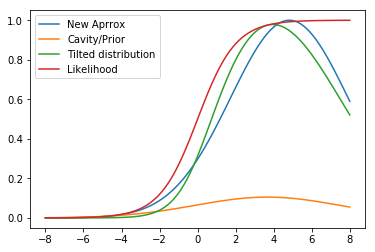

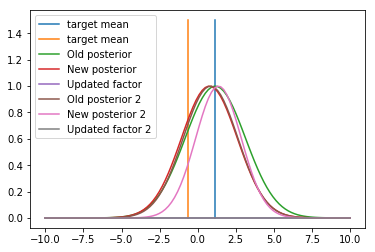

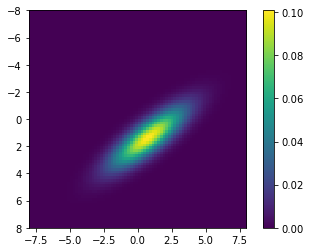

factor  21
Data
[ 1.         -0.81314628]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 1.94262803  2.56490376] [[ 0.90322824  0.90717142]
 [ 0.90717142  1.35861138]]
[ 1.94262803  2.56490376]
[[ 0.90321824  0.90717142]
 [ 0.90717142  1.35860138]]
Cavity
          0
0  0.773097
1  1.371685
          0         1
0  3.361597 -2.244621
1 -2.244621  2.234839

Projected cavity
-0.342285587296 8.489697838

Matched moments 
-2.17793371215 4.65035349078

Updated factor 
-4.40133747417 10.2830307485

Updated factor
      0
0 -32.0
1   0.0
              0             1
0  5.166109e+17  6.353235e+17
1  6.353235e+17  7.813151e+17

New posterior
          0
0 -0.348398
1  2.249946
          0         1
0  1.928512 -1.122348
1 -1.122348  1.355968


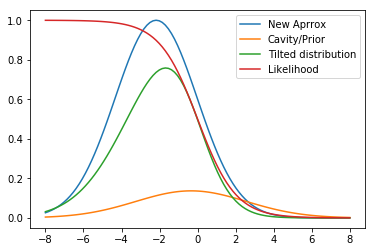

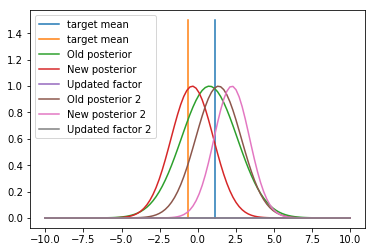

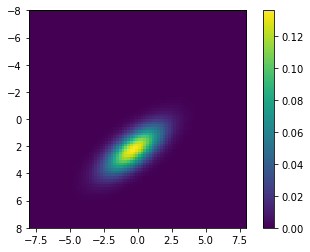

factor  22
Data
[ 1.         3.2408932]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 1.51460855  2.91294621] [[ 1.00046583  0.8280949 ]
 [ 0.8280949   1.42290216]]
[ 1.51460855  2.91294621]
[[ 1.00045583  0.8280949 ]
 [ 0.8280949   1.42289216]]
Cavity
         0
0 -0.34843
1  2.24998
          0         1
0  1.928562 -1.122385
1 -1.122385  1.355999

Projected cavity
6.94348969437 8.89602637391

Matched moments 
7.08460245292 8.16479484187

Updated factor 
8.66024118385 99.3313705285

Updated factor
      0
0  16.0
1   0.0
              0             1
0 -1.077261e+18  3.323962e+17
1  3.323962e+17 -1.025632e+17

New posterior
          0
0 -0.375538
1  2.301885
          0         1
0  1.901576 -1.070714
1 -1.070714  1.257062


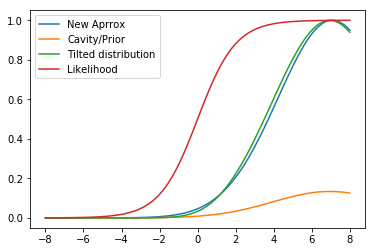

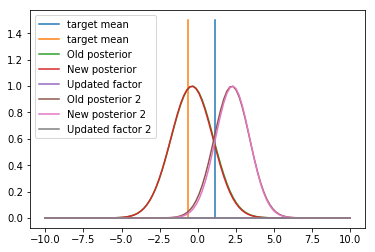

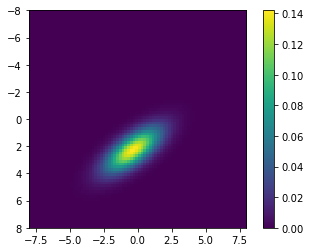

factor  23
Data
[ 1.          0.12898291]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 1.60179391  3.19550465] [[ 1.01052315  0.86072199]
 [ 0.86072199  1.52863306]]
[ 1.60179391  3.19550465]
[[ 1.01051315  0.86072199]
 [ 0.86072199  1.52862306]]
Cavity
          0
0 -0.375569
1  2.301918
          0         1
0  1.901624 -1.070748
1 -1.070748  1.257090

Projected cavity
-0.0786350542029 1.6463087184

Matched moments 
-0.683322144913 1.26143817188

Updated factor 
-2.66522329365 5.39588357399

Updated factor
      0
0  -8.0
1  32.0
              0             1
0  4.333059e+16 -3.359405e+17
1 -3.359405e+17  2.604535e+18

New posterior
          0
0 -1.023299
1  2.635644
          0         1
0  1.460003 -0.843214
1 -0.843214  1.139859


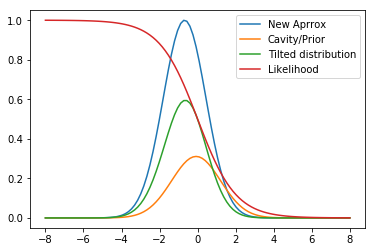

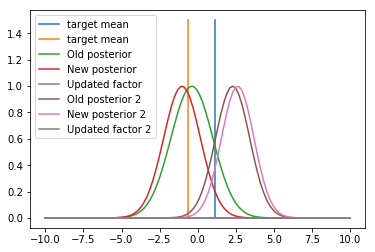

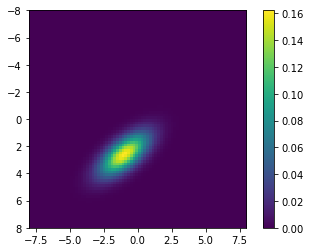

factor  24
Data
[ 1.         0.5619257]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 1.10785751  3.13179529] [[ 1.19583961  0.88462594]
 [ 0.88462594  1.53170626]]
[ 1.10785751  3.13179529]
[[ 1.19582961  0.88462594]
 [ 0.88462594  1.53169626]]
Cavity
          0
0 -1.023336
1  2.635682
          0         1
0  1.460031 -0.843236
1 -0.843236  1.139879

Projected cavity
0.457740133638 0.872283573717

Matched moments 
0.756424929538 0.745471366524

Updated factor 
2.51225717858 5.12775892867

Updated factor
     0
0  8.0
1  8.0
              0             1
0  7.898482e+16 -1.405610e+17
1 -1.405610e+17  2.501416e+17

New posterior
          0
0 -0.685643
1  2.566271
          0         1
0  1.297936 -0.809918
1 -0.809918  1.133031


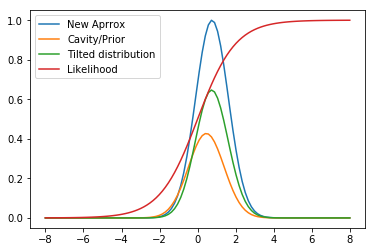

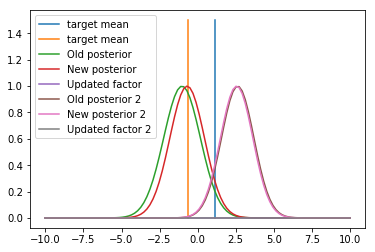

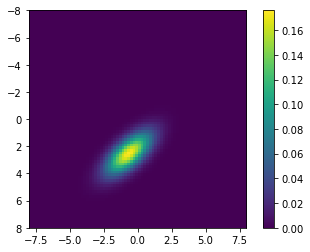

factor  25
Data
[ 1.         -0.61389785]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 1.59779029  3.40710111] [[ 1.39084657  0.99421098]
 [ 0.99421098  1.59327491]]
[ 1.59779029  3.40710111]
[[ 1.39083657  0.99421098]
 [ 0.99421098  1.59326491]]
Cavity
          0
0 -0.685673
1  2.566306
          0         1
0  1.297959 -0.809938
1 -0.809938  1.133050

Projected cavity
-2.26111600566 2.71940877171

Matched moments 
-0.603980455459 1.84158356196

Updated factor 
2.87251299142 5.70502924344

Updated factor
     0
0  0.0
1  0.0
              0             1
0  5.472214e+16  8.913884e+16
1  8.913884e+16  1.452014e+17

New posterior
          0
0  0.408262
1  1.648884
          0         1
0  0.915421 -0.489125
1 -0.489125  0.864003


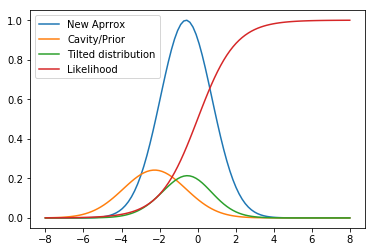

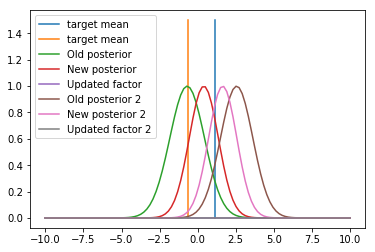

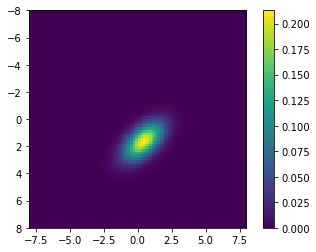

factor  26
Data
[ 1.          1.95008842]
1.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 2.10129568  3.09800024] [[ 1.56612051  0.88660455]
 [ 0.88660455  1.65932427]]
[ 2.10129568  3.09800024]
[[ 1.56611051  0.88660455]
 [ 0.88660455  1.65931427]]
Cavity
          0
0  0.408258
1  1.648896
          0         1
0  0.915432 -0.489134
1 -0.489134  0.864012

Projected cavity
3.6237489484 2.29342633761

Matched moments 
3.74143083504 2.09738331721

Updated factor 
5.00046074222 24.5364212903

Updated factor
     0
0  0.0
1  4.0
              0             1
0  1.998185e+17 -1.024664e+17
1 -1.024664e+17  5.254447e+16

New posterior
          0
0  0.406286
1  1.710254
          0         1
0  0.915377 -0.487421
1 -0.487421  0.810719


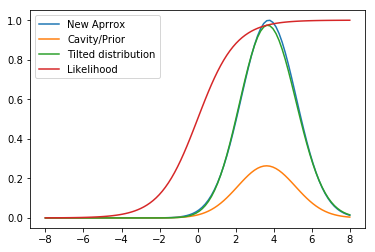

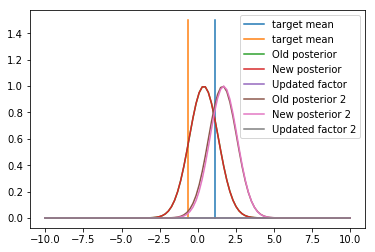

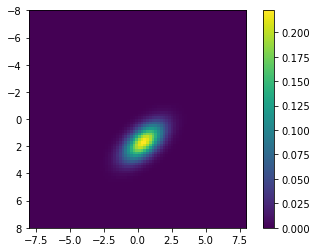

factor  27
Data
[ 1.          0.40198936]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 2.30509316  3.49542333] [[ 1.60686625  0.96608184]
 [ 0.96608184  1.81430202]]
[ 2.30509316  3.49542333]
[[ 1.60685625  0.96608184]
 [ 0.96608184  1.81429202]]
Cavity
          0
0  0.406282
1  1.710266
          0         1
0  0.915388 -0.487430
1 -0.487430  0.810728

Projected cavity
1.09379639857 0.654513101367

Matched moments 
0.671768416903 0.577433268824

Updated factor 
-2.48979783138 4.90319746609

Updated factor
     0
0 -8.0
1  8.0
              0             1
0  4.977614e+16 -1.238245e+17
1 -1.238245e+17  3.080294e+17

New posterior
          0
0 -0.057614
1  1.814417
          0         1
0  0.822256 -0.466520
1 -0.466520  0.806033


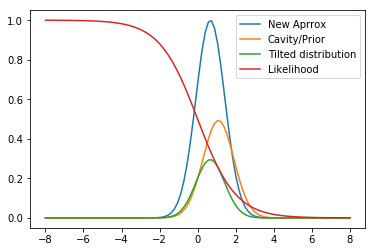

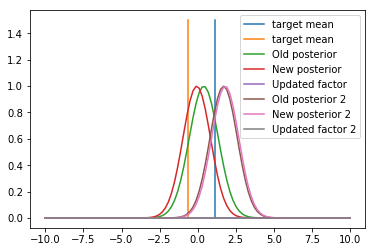

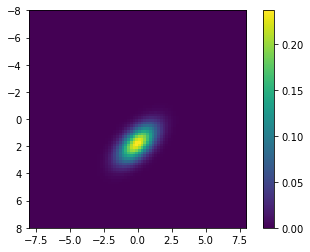

factor  28
Data
[ 1.          0.46566244]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 1.79730251  3.29129689] [[ 1.8108048   1.04806699]
 [ 1.04806699  1.84724918]]
[ 1.79730251  3.29129689]
[[ 1.8107948   1.04806699]
 [ 1.04806699  1.84723918]]
Cavity
          0
0 -0.057623
1  1.814432
          0         1
0  0.822265 -0.466528
1 -0.466528  0.806042

Projected cavity
0.787295283724 0.562557850559

Matched moments 
0.44991078013 0.501590714367

Updated factor 
-2.32582947508 4.62829340129

Updated factor
       0
0  128.0
1  256.0
              0             1
0 -2.090156e+18  4.488565e+18
1  4.488565e+18 -9.639095e+18

New posterior
          0
0 -0.420473
1  1.869118
          0        1
0  0.751746 -0.45590
1 -0.455900  0.80444


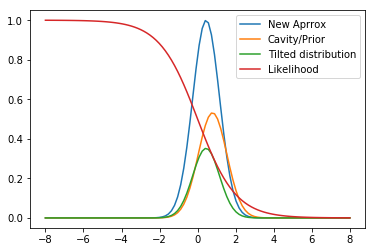

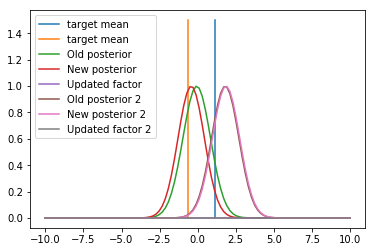

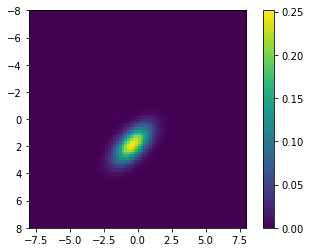

factor  29
Data
[ 1.         -0.87079715]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 1.2947783   3.05729025] [[ 2.02685716  1.14867912]
 [ 1.14867912  1.89409047]]
[ 1.2947783   3.05729025]
[[ 2.02684716  1.14867912]
 [ 1.14867912  1.89408047]]
Cavity
          0
0 -0.420485
1  1.869135
          0         1
0  0.751754 -0.455907
1 -0.455907  0.804449

Projected cavity
-2.04812075132 2.15576227833

Matched moments 
-2.35034546184 1.78799051632

Updated factor 
-3.81966685086 10.4806374693

Updated factor
      0
0  32.0
1   0.0
              0             1
0  4.296085e+17  4.933508e+17
1  4.933508e+17  5.665508e+17

New posterior
          0
0 -0.581533
1  2.031258
          0         1
0  0.647322 -0.350779
1 -0.350779  0.698619


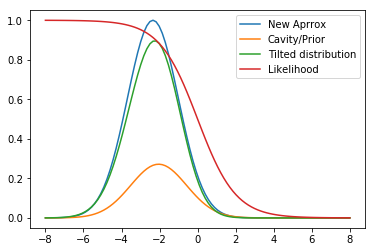

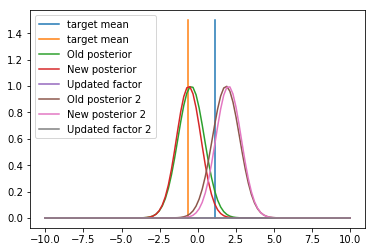

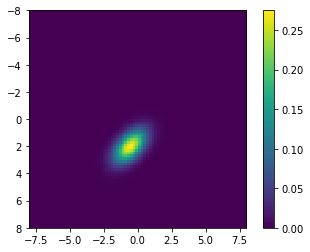

factor  30
Data
[ 1.         -0.67246045]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 0.93032844  3.37465214] [[ 2.12226121  1.06559284]
 [ 1.06559284  1.96643176]]
[ 0.93032844  3.37465214]
[[ 2.12225121  1.06559284]
 [ 1.06559284  1.96642176]]
Cavity
          0
0 -0.581544
1  2.031274
          0         1
0  0.647328 -0.350783
1 -0.350783  0.698625

Projected cavity
-1.94749287244 1.4350236663

Matched moments 
-2.15626240471 1.24717455604

Updated factor 
-3.54233257755 9.5274606379

Updated factor
      0
0   0.0
1 -16.0
              0             1
0 -2.015244e+17 -2.996822e+17
1 -2.996822e+17 -4.456502e+17

New posterior
          0
0 -0.710035
1  2.150653
          0         1
0  0.576170 -0.284671
1 -0.284671  0.637202


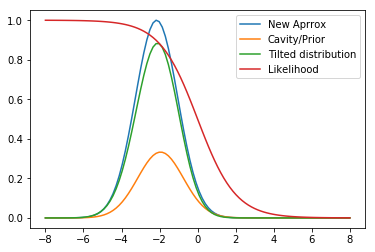

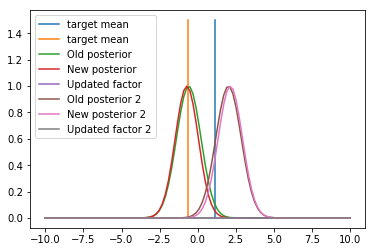

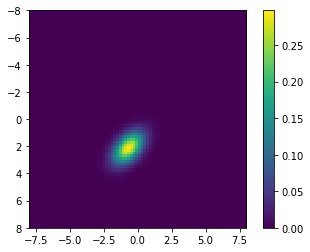

factor  31
Data
[ 1.         -1.16514984]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 0.55852606  3.62467454] [[ 2.22721097  0.99501155]
 [ 0.99501155  2.01388489]]
[ 0.55852606  3.62467454]
[[ 2.22720097  0.99501155]
 [ 0.99501155  2.01387489]]
Cavity
          0
0 -0.710046
1  2.150669
          0         1
0  0.576174 -0.284675
1 -0.284675  0.637207

Projected cavity
-3.21589741086 2.104606989

Matched moments 
-3.35614658292 1.89736077006

Updated factor 
-4.64014239456 19.2678966968

Updated factor
     0
0 -4.0
1 -4.0
              0             1
0  1.297345e+17  1.113458e+17
1  1.113458e+17  9.556347e+16

New posterior
          0
0 -0.770545
1  2.219115
          0         1
0  0.537610 -0.241045
1 -0.241045  0.587846


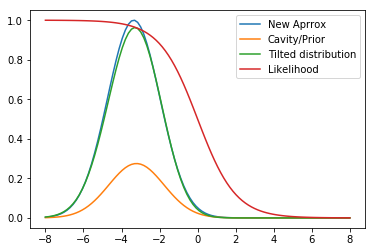

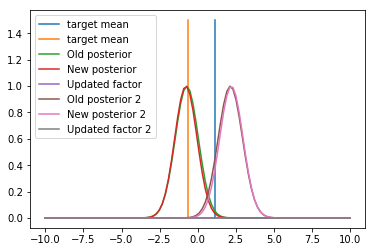

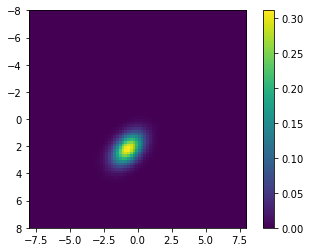

factor  32
Data
[ 1.         -0.40317695]
0.0

Current factor
     0
0  0.0
1  0.0
          0         1
0  100000.0       0.0
1       0.0  100000.0

removal
[0 0] [[  1.00000000e-05   0.00000000e+00]
 [  0.00000000e+00   1.00000000e-05]] [ 0.31770359  3.9052688 ] [[ 2.27910077  0.93454051]
 [ 0.93454051  2.08433272]]
[ 0.31770359  3.9052688 ]
[[ 2.27909077  0.93454051]
 [ 0.93454051  2.08432272]]
Cavity
          0
0 -0.770554
1  2.219130
          0         1
0  0.537613 -0.241048
1 -0.241048  0.587850

Projected cavity
-1.66525274034 0.827538250988

Matched moments 
-1.80637799237 0.749056436692

Updated factor 
-3.15332415254 7.89829923107

Updated factor
     0
0 -4.0
1  0.0
              0             1
0  6.162014e+16  1.528365e+17
1  1.528365e+17  3.790803e+17

New posterior
          0
0 -0.878810
1  2.300656
          0         1
0  0.491432 -0.206270
1 -0.206270  0.561659


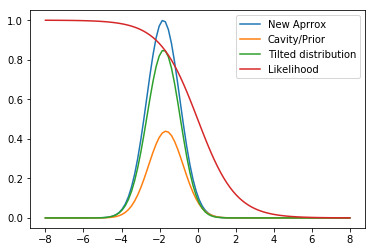

KeyboardInterrupt: 

In [14]:
# Outer loop
mu, sig = ss_to_cov(r_new, A_new)
plot_posterior(mu, sig)
for iteration in xrange(3): # max iterations
    print "Iteration ", iteration

    for i in xrange(N):
        
        ######################################################################################
        
        print "factor ", i
        print "Data"
        print data[i]
        print y[i]
        print
        print "Current factor"
        a,b = ss_to_cov(r[i], A[i])
        print pd.DataFrame(a)
        print pd.DataFrame(b)
        print
        
        ######################################################################################
        
        # 1 get cavity distribution 
        
        r_cavity, A_cavity = compute_cavity(r[i], A[i], r_old, A_old)
        print "removal"
        print r[i], A[i], r_old, A_old
        print r_cavity
        print A_cavity
        # verbose
        print "Cavity"
        a,b = ss_to_cov(r_cavity, A_cavity)
        print pd.DataFrame(a)
        print pd.DataFrame(b)
        print
        
        ######################################################################################
        
        # 2 project the cavity distribution onto 1d subspace
       
        Mi, Vi = project_factor_subspace(data[i], r[i],A[i])
        mu, sig = ss_to_cov(r_new, A_new)
        M_cavity, V_cavity = project_subspace(data[i], mu, sig, Mi, Vi)
        
        # verbose
        print "Projected cavity"
        print M_cavity, V_cavity
        print
        
        
        ######################################################################################

        # 3 compute moments
        
        # Numerical integration
        
        M_new, V_new = compute_moments(y[i], M_cavity, V_cavity)
        
        # alternatively match moments with Laplace approximation
        # Laplace approximation
        
        #max_x = optimize.minimize(lambda x: -ll(x, y[i], M_cavity, V_cavity),  M_cavity)
        #M_new = max_x.x[0]
        #V_new = max_x.hess_inv[0][0]
        
        # verbose
        print "Matched moments "
        print M_new, V_new
        print
        
        if V_new == 0:
            V_new = np.infty
            print " WARNING MATCHED VARIANCE IS 0\n"
            #break


        ###################################################################################### 
         
        # 4 subtract cavity to get moments of updated approximating factor
        
        Mi_approx, Vi_approx = subtract_moments(M_new, V_new, M_cavity, V_cavity)
        
        # verbose
        print "Updated factor "
        print Mi_approx, Vi_approx
        print
        
        ######################################################################################
        
        # 5 Transform updated factor back 
        
        r[i], A[i] = transform_back(data[i], Mi_approx, Vi_approx)
        
        # verbose
        print "Updated factor"
        a, b = ss_to_cov(r[i], A[i])
        print pd.DataFrame(a)
        print pd.DataFrame(b)
        print
        
        ######################################################################################    

        # 6 combine updated gi with cavity 
        r_new, A_new = update_post(r[i], A[i], r_cavity, A_cavity)
        
        # verbose
        print "New posterior"
        a,b = ss_to_cov(r_new, A_new)
        print pd.DataFrame(a)
        print pd.DataFrame(b)  

        ###################################################################################### 
        
        mu, sig = ss_to_cov(r_new, A_new)
        
        if sig[0][0] >= 0 and sig[1][1] >= 0:
            
            # plot
            plot_projected(M_new, V_new, M_cavity, V_cavity, y[i])
            plot_posterior_1d(r_old, A_old, r_new, A_new, r[i], A[i])
            plot_posterior(mu, sig)
            
            r_old = r_new
            A_old = A_new
            
        else:
            print "WARNING NEG VAR POSTERIOR"
        

In [ ]:
print np.linalg.inv(np.array([[-0.48206052 , 0.  ],[ 0.,1.16445785]]))

In [ ]:
plot_projected(M_new, V_new, M_cavity, V_cavity, y[i])
plot_posterior_1d(r_old, A_old, r_new, A_new, r[i], A[i])
plot_posterior(mu, sig)